In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [110]:
df = pd.read_csv('Data.csv', encoding='cp1250')

In [111]:
df.columns

Index(['Kód okresu', 'Název okresu', 'Věk', 'Pohlaví', 'Rodinný stav',
       'Nejvyšší dosažené vzdělání', 'Počet osob'],
      dtype='object')

In [112]:
df.head()

,Kód okresu,Název okresu,Věk,Pohlaví,Rodinný stav,Nejvyšší dosažené vzdělání,Počet osob
0,CZ0201,Benešov,0,muž,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,507
1,CZ0201,Benešov,0,žena,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,504
2,CZ0201,Benešov,1,muž,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,513
3,CZ0201,Benešov,1,žena,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,538
4,CZ0201,Benešov,2,muž,Svobodný/svobodná,nedefinováno - osoby ve věku 0–14 let,565


In [113]:
df.dtypes

Kód okresu                    object
Název okresu                  object
Věk                           object
Pohlaví                       object
Rodinný stav                  object
Nejvyšší dosažené vzdělání    object
Počet osob                     int64
dtype: object

In [114]:
poc_cisla = df['Kód okresu'].str[3:5].unique()
for cislo in poc_cisla:
    mask = df['Kód okresu'].str[3:5] == cislo
    okresy = df.loc[mask, 'Název okresu'].unique()
    print(f"{cislo}: {okresy}")

20: ['Benešov' 'Beroun' 'Kladno' 'Kolín' 'Kutná Hora' 'Mělník'
 'Mladá Boleslav' 'Praha-západ' 'Nymburk' 'Praha-východ' 'Příbram'
 'Rakovník']
31: ['České Budějovice' 'Český Krumlov' 'Jindřichův Hradec' 'Písek'
 'Prachatice' 'Strakonice' 'Tábor']
32: ['Domažlice' 'Klatovy' 'Plzeň-město' 'Plzeň-jih' 'Plzeň-sever' 'Rokycany'
 'Tachov']
41: ['Cheb' 'Karlovy Vary' 'Sokolov']
42: ['Děčín' 'Chomutov' 'Litoměřice' 'Louny' 'Most' 'Teplice' 'Ústí nad Labem']
51: ['Česká Lípa' 'Jablonec nad Nisou' 'Liberec' 'Semily']
52: ['Hradec Králové' 'Jičín' 'Náchod' 'Rychnov nad Kněžnou' 'Trutnov']
53: ['Chrudim' 'Pardubice' 'Svitavy' 'Ústí nad Orlicí']
63: ['Havlíčkův Brod' 'Jihlava' 'Pelhřimov' 'Třebíč' 'Žďár nad Sázavou']
64: ['Blansko' 'Brno-město' 'Brno-venkov' 'Břeclav' 'Hodonín' 'Vyškov'
 'Znojmo']
71: ['Jeseník' 'Olomouc' 'Prostějov' 'Přerov' 'Šumperk']
72: ['Kroměříž' 'Uherské Hradiště' 'Vsetín' 'Zlín']
80: ['Bruntál' 'Frýdek-Místek' 'Karviná' 'Nový Jičín' 'Opava' 'Ostrava-město']
10: ['Praha']


# Pohlaví - vzdělání

In [115]:
df.groupby('Pohlaví')

In [116]:
df.shape

(404968, 7)

In [117]:
def split_by(df: pd.DataFrame, column: str) -> list:
    return [df[df[column] == column_type]['Věk'] for column_type in df[column].unique()]

In [118]:
def convert_age_to_int(s: str) -> int:
    return 100 if s.endswith('+') else int(s)
df['Věk'] = df['Věk'].apply(convert_age_to_int)

In [119]:
education = pd.DataFrame(columns=['Věk', 'Pohlaví', 'Vysokoškolsky vzdělaný', 'Počet osob', 'Poměr vzdělaných'])
for age in df['Věk'].unique():
    df_age = df[df['Věk'] == age]
    for gender in ('muž', 'žena'):
        df_gender = df_age[df_age['Pohlaví'] == gender]
        total = df_gender['Počet osob'].astype(int).sum()
        educated = df_gender[df_gender['Nejvyšší dosažené vzdělání'].isin(['bakalářské', 'vyšší odborné vzdělání', 'magisterské', 'doktorské'])]['Počet osob'].astype(int).sum()
        percentage_educated = educated / total * 100
        new_row = pd.DataFrame([[age, gender, educated, total, percentage_educated]], columns = education.columns)
        if education.empty:
            education = new_row
        else:
            education = pd.concat([education, new_row])

df_edu = education.pivot(index = 'Věk', columns = 'Pohlaví', values = 'Vysokoškolsky vzdělaný')
df_pop = education.pivot(index = 'Věk', columns = 'Pohlaví', values = 'Počet osob')
df_perc = education.pivot(index = 'Věk', columns = 'Pohlaví', values = 'Poměr vzdělaných')

In [120]:
def group_ages(df: pd.DataFrame, age_column: str) -> pd.DataFrame:
    df = df.reset_index()
    age_bins = [19, 29, 39, 49, 59, 69, 79, 100]
    age_labels = ['20-29', '30-39','40-49', '50-59', '60-69', '70-79', '80+']
    df[age_column] = pd.cut(df[age_column], bins=age_bins, labels=age_labels, right=True)
    return df.groupby(age_column).sum().reset_index()

df_edu_age = group_ages(df_edu, 'Věk')
df_pop_age = group_ages(df_pop, 'Věk')
df_perc_age = pd.DataFrame(columns=['Věk', 'muž', 'žena'])
for age in df_edu_age['Věk'].unique():
    edu_men = df_edu_age[df_edu_age['Věk'] == age]['muž'].iloc[0]
    edu_women = df_edu_age[df_edu_age['Věk'] == age]['žena'].iloc[0]
    pop_men = df_pop_age[df_pop_age['Věk'] == age]['muž'].iloc[0]
    pop_women = df_pop_age[df_pop_age['Věk'] == age]['žena'].iloc[0]
    perc_men = edu_men / pop_men * 100
    perc_women = edu_women / pop_women * 100
    new_row = pd.DataFrame([[age, perc_men, perc_women]], columns=df_perc_age.columns)
    if df_perc_age.empty:
        df_perc_age = new_row
    else:
        df_perc_age = pd.concat([df_perc_age, new_row])

C:\Users\svest\AppData\Local\Temp\ipykernel_15508\926376067.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(age_column).sum().reset_index()
C:\Users\svest\AppData\Local\Temp\ipykernel_15508\926376067.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(age_column).sum().reset_index()


In [121]:
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
import math

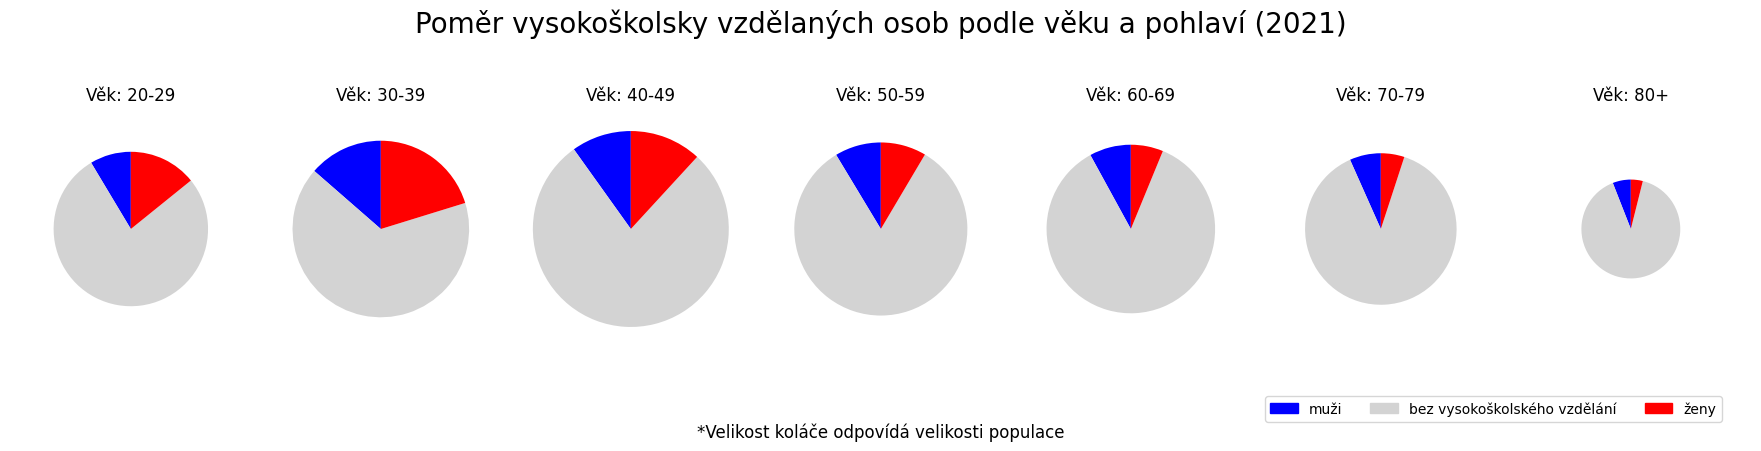

In [122]:
ages = df_edu_age['Věk'].tolist()
n = len(ages)
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(2.5*n, 4), constrained_layout = True)

for ax, age in zip(axes, ages):
    edu_m = df_edu_age .loc[df_edu_age ['Věk']==age, 'muž'].iloc[0]
    pop_m = df_pop_age .loc[df_pop_age ['Věk']==age, 'muž'].iloc[0]
    edu_f = df_edu_age .loc[df_edu_age ['Věk']==age, 'žena'].iloc[0]
    pop_f = df_pop_age .loc[df_pop_age ['Věk']==age, 'žena'].iloc[0]

    ax.pie(
        [edu_m, pop_m + pop_f - edu_m - edu_f, edu_f],
        colors=['blue','lightgray','red'],
        startangle=90,
        radius= math.sqrt((pop_m + pop_f)) / 1_300,
    )

    ax.set_title(f'Věk: {age}')

blue_patch  = mpatches.Patch(color='blue',   label='muži')
gray_patch  = mpatches.Patch(color='lightgray', label='bez vysokoškolského vzdělání')
red_patch   = mpatches.Patch(color='red',    label='ženy')

fig.suptitle('Poměr vysokoškolsky vzdělaných osob podle věku a pohlaví (2021)',fontsize=20, y=1.05)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend([blue_patch, gray_patch, red_patch], ['muži', 'bez vysokoškolského vzdělání', 'ženy'],
           loc='upper center', bbox_to_anchor=(0.85, 0.1), ncol=3)
fig.text(0.5, -0.02,
         "*Velikost koláče odpovídá velikosti populace",
         ha="center", fontsize=12)
plt.show()

fig.savefig(
    "vzdelanost_kolace.pdf",
    format="pdf",
    bbox_inches="tight"
)

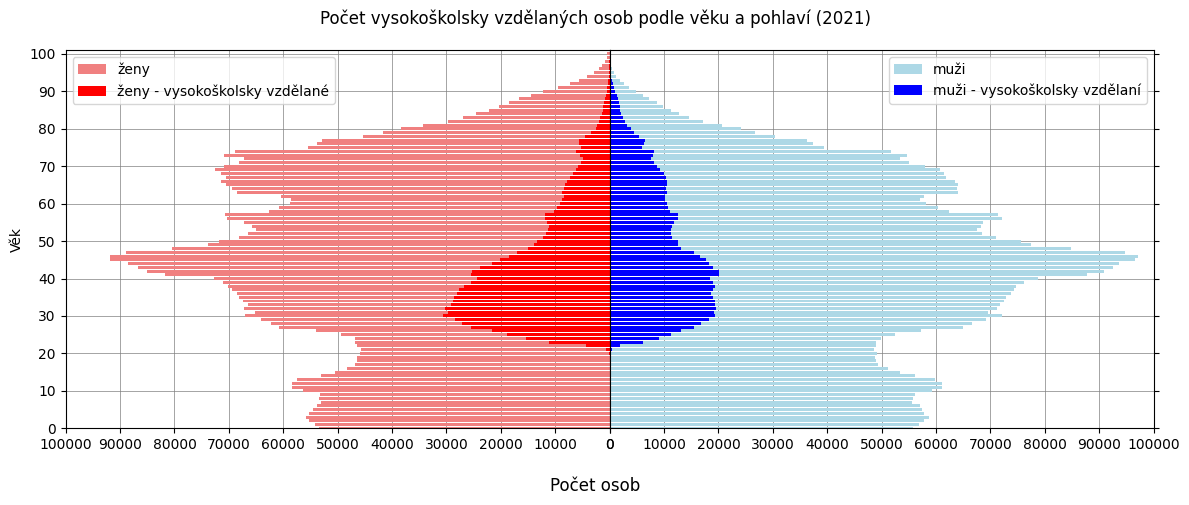

In [123]:
ages = df_edu.index
male = df_edu.get('muž')
female = df_edu.get('žena')
male_pop = df_pop.get('muž')
female_pop = df_pop.get('žena')
y = np.arange(len(ages))
height = 0.8
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'wspace': 0})

max_pop = 100000
locator = ticker.MultipleLocator(10000)
xticks = np.arange(0, max_pop+1, 10000)
yticks = np.arange(0, 101, 10)
fmt = ticker.FuncFormatter(lambda x, pos: f"{abs(int(x)):,}")



# Plot left
ax1.barh(y = y, width = -female_pop, height = height, label = 'ženy', color = 'lightcoral')
ax1.barh(y = y, width = -female, height = height, label = 'ženy - vysokoškolsky vzdělané', color = 'red')

ax1.set_xlim(-max_pop, 0)
ax1.set_xticks(-xticks)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: abs(int(x))))

ax1.set_ylabel('Věk')



# Plot right
ax2.barh(y = y, width = male_pop, height = height, label = 'muži', color = 'lightblue')
ax2.barh(y = y, width = male, height = height, label = 'muži - vysokoškolsky vzdělaní', color = 'blue')

ax2.set_xlim(0, max_pop)
ax2.set_xticks(xticks)

ax2.yaxis.tick_right()


# Both
for ax in (ax1, ax2):
    ax.set_ylim(0, 101)
    ax.set_yticks(yticks)
    ax.set_axisbelow(True)       
    ax.grid(axis='x', color='gray', linewidth=0.5)
    ax.grid(axis='y', color='gray', linewidth=0.5)
    ax.legend()

fig.suptitle("Počet vysokoškolsky vzdělaných osob podle věku a pohlaví (2021)")
fig.supxlabel("Počet osob")


plt.tight_layout()
plt.show()

fig.savefig(
    "vzdelanost_populacni_pyramida.pdf",
    format="pdf",
    bbox_inches="tight"
)

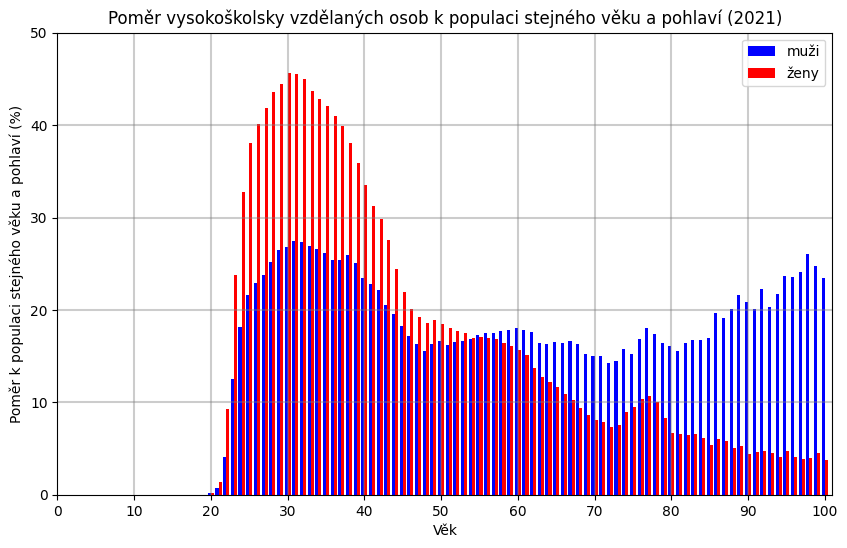

In [124]:
ages = df_perc.index
male = df_perc.get('muž')
female = df_perc.get('žena')
x = np.arange(len(ages))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
xticks = np.arange(0, 101, 10)

ax.hlines(np.arange(10, 100, 10), xmin = 0, xmax = 200, color = 'grey', alpha = 0.4)
ax.bar(x = x - width / 2, height = male, width = width, label = 'muži', color = 'blue')
ax.bar(x = x + width / 2, height = female, width = width, label = 'ženy', color = 'red')

ax.set_xlim(0, 101)
ax.set_xlabel('Věk')
ax.set_xticks(xticks)
ax.vlines(np.arange(10, 100, 10), ymin = 0, ymax = 200, color = 'grey', alpha = 0.4)

ax.set_ylim(0, 50)
ax.set_ylabel('Poměr k populaci stejného věku a pohlaví (%)')

ax.set_title('Poměr vysokoškolsky vzdělaných osob k populaci stejného věku a pohlaví (2021)')
ax.legend()
plt.show()

fig.savefig(
    "vzdelanost_podle veku.pdf",
    format="pdf",
    bbox_inches="tight"
)

In [125]:
df.columns

Index(['Kód okresu', 'Název okresu', 'Věk', 'Pohlaví', 'Rodinný stav',
       'Nejvyšší dosažené vzdělání', 'Počet osob'],
      dtype='object')

In [126]:
df["Rodinný stav"].unique()

array(['Svobodný/svobodná', 'Nezjištěno', 'Ženatý/vdaná', 'Vdovec/vdova',
       'Registrované partnerství trvající', 'Rozvedený/rozvedená',
       'Registrované partnerství zaniklé rozhodnutím soudu',
       'Registrované partnerství zaniklé úmrtím partnera/partnerky'],
      dtype=object)

In [127]:
columns = ['Municipality', 'Region_code', 'Population', 'Divorced', 'Married', 'Gay_married', 'Educated']
data = pd.DataFrame(columns=columns)
for okres in df['Název okresu'].unique():
    df_okres = df[df['Název okresu'] == okres]
    region_code = df_okres['Kód okresu'].iloc[0][3:5]
    population = df_okres['Počet osob'].astype(int).sum()
    divorced = df_okres[df_okres['Rodinný stav'] == 'Rozvedený/rozvedená']['Počet osob'].astype(int).sum()
    married = df_okres[df_okres['Rodinný stav'] == 'Rozvedený/rozvedená']['Počet osob'].astype(int).sum()
    gay = df_okres[df_okres['Rodinný stav'] == 'Registrované partnerství trvající']['Počet osob'].astype(int).sum()
    educated = df_okres[df_okres['Nejvyšší dosažené vzdělání'].isin(['bakalářské', 'vyšší odborné vzdělání', 'magisterské', 'doktorské'])]['Počet osob'].astype(int).sum()
    new_row = pd.DataFrame([[okres, region_code, population, divorced, married, gay, educated]], columns = columns)
    if data.empty:
        data = new_row
    else:
        data = pd.concat([data, new_row])

In [128]:
region_dict = {
    20: "Středočeský kraj",
    31: "Jihočeský kraj",
    32: "Plzeňský kraj",
    41: "Karlovarský kraj",
    42: "Ústecký kraj",
    51: "Liberecký kraj",
    52: "Královéhradecký kraj",
    53: "Pardubický kraj",
    63: "Kraj Vysočina",
    64: "Jihomoravský kraj",
    71: "Olomoucký kraj",
    72: "Zlínský kraj",
    80: "Moravskoslezský kraj",
    10: "Hlavní město Praha"
}

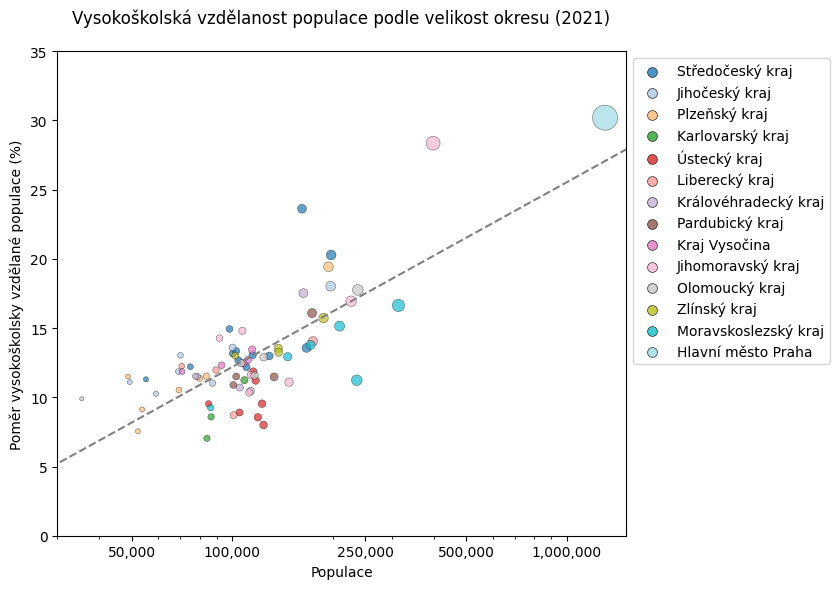

In [132]:
# --- your data prep ---
x = data['Population'].values
y = data['Educated'].values / x * 100
codes, uniques = pd.factorize(data['Region_code'])
cmap = plt.get_cmap('tab20', len(uniques))

# --- compute trendline ---
m, b = np.polyfit(np.log(x), y, 1)
xx = np.linspace(25_000, 2_000_000, 200)

# --- figure & axes ---
fig, ax = plt.subplots(figsize=(10, 6))

# scatter
sc = ax.scatter(x, y,
                c=codes,
                cmap=cmap,
                s=x / 4_000,
                alpha=0.7,
                edgecolor='k',
                linewidth=0.3)

# trendline
ax.plot(xx, m * np.log(xx) + b,
        color='gray',
        ls='--',
        lw=1.5)

# scales & limits
ax.set_xscale('log')
ax.set_xlim(30_000, 1_500_000)
ax.set_ylim(0, 35)

# labels & title
ax.set_xlabel('Populace')
ax.set_ylabel('Poměr vysokoškolsky vzdělané populace (%)')
ax.set_title('Vysokoškolská vzdělanost populace podle velikost okresu (2021)',
             pad=20)

# custom x-ticks & formatting
ticks = [50_000, 100_000, 250_000, 500_000, 1_000_000]
ax.set_xticks(ticks)
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda val, pos: f"{int(val):,}")
)

# manual legend entries for regions
for i, region in enumerate(uniques):
    ax.scatter([], [],
               c=[cmap(i)],
               s=50,
               alpha=0.8,
               edgecolor='k',
               linewidth=0.5,
               label=region_dict[int(region)])

leg = ax.legend(bbox_to_anchor=(1, 1),
                loc='upper left',
                borderaxespad=0.5)

# adjust layout to make room for title & legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# save to PDF
fig.savefig("vzdelanost_podle_okresu.pdf",
            format="pdf",
            bbox_inches="tight",
            dpi=300)

# finally display
plt.show()

In [130]:
data.head(30)

,Municipality,Region_code,Population,Divorced,Married,Gay_married,Educated
0,Benešov,20,100347,10915,10915,44,13206
0,Beroun,20,98073,10936,10936,61,14651
0,Kladno,20,166771,21428,21428,144,22629
0,Kolín,20,104227,12267,12267,61,13212
0,Kutná Hora,20,74918,8717,8717,23,9143
0,Mělník,20,110243,13353,13353,68,13429
0,Mladá Boleslav,20,128901,15158,15158,46,16740
0,Praha-západ,20,161593,16091,16091,99,38170
0,Nymburk,20,102727,12333,12333,70,13707
0,Praha-východ,20,197477,19958,19958,142,40054
